(64, 200, 3)


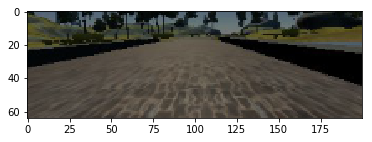

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from math import floor, ceil
import numpy as np
%matplotlib inline

#Load driving log:

driving_log = pd.read_csv(
    'driving_log.csv',
    names = ['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],
    header = None,
    skiprows = 1)

#Load and preprocess images:

def load_image(path, flip=False):
    image = cv2.imread(path)
    #Convert to RGB
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)    
    #Crop image, remove sky and the bottom part. Leave some of both for bumpy sections.
    #image = image[floor(image.shape[0]*0.2):floor(image.shape[0]*0.88),:,:]
    shape = image.shape
    image = image[floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    #Lower resolution, still doesn't affect network's performance
    #image = cv2.resize(image, (0,0), fx=0.5, fy=0.5)
    image = cv2.resize(image, (200, 64)) 
    #Randomly change brightness (Vivek's idea)    
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image[:,:,2] = image[:,:,2]*random_bright
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    
    #Flip image
    if flip:
        #image = np.asarray(image)[:,::-1,:]
        image = cv2.flip(image, 1)
    
    return image

image = load_image(driving_log['Left'][0].strip(), True)
print (image.shape)
plt.figure()
plt.imshow(image)

#center_images = np.array([load_image(path.strip()) for path in driving_log['Center']], dtype=np.float32)
#left_images = np.array([load_image(path.strip()) for path in driving_log['Left']], dtype=np.float32)
#right_images = np.array([load_image(path.strip()) for path in driving_log['Right']], dtype=np.float32)

In [7]:
def generator_train(data, batch_size = 100):
    
    while True:    
    
        X_Train_list, Y_Train_list = [], []
        counter = 0
        #for counter in range(batch_size):
        while counter < batch_size:
            idx = np.random.randint(len(data))

            #Half the time we'll skip image if angle == 0.0.
            #We do this to rebalance the dataset, as more than half of the images
            #have 0.0 as steering angle
            if data['Steering Angle'][idx] == 0.0 and np.random.randint(2) == 0:                
                continue
            else:
                #Each camera image has a probability of 33% of being chosen
                #For the left and right camera, the steering angle needs to be
                #compensated (+0.25/-0.25)
                image_choice = np.random.randint(3)
                if image_choice == 0:
                    X_Train_list.append(data['Center'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx])
                elif image_choice == 1:
                    X_Train_list.append(data['Left'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx] +.25)
                else:
                    X_Train_list.append(data['Right'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx] -.25)
        
                counter += 1

        X_Train_regular = [load_image(path.strip()) for path in X_Train_list[0:ceil(batch_size/2.0)]]        
        Y_Train_regular = [angle for angle in Y_Train_list[0:ceil(batch_size/2.0)]]
        #We'll flip half the batch
        X_Train_flipped = [load_image(path.strip(), True) for path in X_Train_list[ceil(batch_size/2.0):]]
        Y_Train_flipped = [-angle for angle in Y_Train_list[ceil(batch_size/2.0):]]
        X_Train = np.array(X_Train_regular + X_Train_flipped)
        Y_Train = np.array(Y_Train_regular + Y_Train_flipped)
                
        yield X_Train, Y_Train

In [8]:
def generator_val(data, batch_size = 100):
    while True:
        X_Val_list, Y_Val_list = [], []
        counter = 0
        #for counter in range(batch_size):
        while counter < batch_size:
            idx = np.random.randint(len(data))
            image_choice = np.random.randint(3)
            if image_choice == 0:
                X_Val_list.append(data['Center'][idx])
                Y_Val_list.append(data['Steering Angle'][idx])
            elif image_choice == 1:
                X_Val_list.append(data['Left'][idx])
                Y_Val_list.append(data['Steering Angle'][idx] +.25)
            else:
                X_Val_list.append(data['Right'][idx])
                Y_Val_list.append(data['Steering Angle'][idx] -.25)

            counter += 1

        X_Val = np.array([load_image(path.strip()) for path in X_Val_list])
        Y_Val = np.array([angle for angle in Y_Val_list])
        
        yield X_Val, Y_Val

In [ ]:
gen_t = generator_train(driving_log, batch_size = 50)
gen_v = generator_val(driving_log, batch_size = 50)

image_t, angle_t = next(gen_t)
image_v, angle_v = next(gen_v)

plt.figure()
plt.imshow(image_t[0])
print (angle_t[0])
print (image_t[0].shape)

plt.figure()
plt.imshow(image_v[0])
print (angle_v[0])

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Lambda
#from keras.layers import Input, ELU
#from keras.optimizers import SGD, Adam, RMSprop
#from keras.utils import np_utils
from keras.layers import Convolution2D, Flatten
#from keras import initializations
#import keras.backend as K

#K.set_image_dim_ordering('tf')

def nvidia_dnn():
    
    #Images shape after preprocessing
    input_shape = (64, 200, 3)
    #input_shape = (200, 64, 3)
    #input_shape = (3, 160, 54)
    #input_shape = (3, 54, 160)
    
    #(width, height, channels)  # Known as 'tf' ordering
    #(channels, width, height)  # Known as 'th' ordering
    
    model = Sequential()
    #Scale images pixel values between -0.5 and 0.5
    model.add(Lambda(lambda x:x/255.-.5, input_shape = input_shape))    
    
    model.add(Convolution2D(24, 5, 5, init = 'normal', border_mode='valid', subsample = (2, 2), name = 'conv1', input_shape = input_shape))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(36, 5, 5, init = 'normal', border_mode='valid', subsample = (2, 2), name = 'conv2'))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 5, 5, init = 'normal', border_mode='valid', subsample = (2, 2), name = 'conv3'))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3, init = 'normal', border_mode='valid', subsample = (1, 1), name = 'conv4'))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3, init = 'normal', border_mode='valid', subsample = (1, 1), name = 'conv5'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(1164, init = 'normal', name = 'dense1'))
    model.add(Activation('relu'))
    
    model.add(Dense(100, init = 'normal', name = 'dense2'))
    model.add(Activation('relu'))
    
    model.add(Dense(50, init = 'normal', name = 'dense3'))
    model.add(Activation('relu'))
    
    model.add(Dense(1, init = 'normal', name = 'dense4'))
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

Using TensorFlow backend.


In [ ]:
model = nvidia_dnn()

train_generator = generator_train(driving_log, batch_size = 50)
val_generator = generator_val(driving_log, batch_size = 50)

samples_per_epoch = 24100 #~Full dataset
nb_val_samples = 2400 #~10% of the dataset

history = model.fit_generator(
    train_generator, 
    samples_per_epoch = samples_per_epoch, 
    nb_epoch = 10,
    validation_data = val_generator,
    nb_val_samples = nb_val_samples)

#fileModelJSON = 'model_' + str(i_pr) + '.json'
#fileWeights = 'model_' + str(i_pr) + '.h5'
from pathlib import Path
import json
import os

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save(fileWeights)
    
fileModelJSON = 'model.json'
fileWeights = 'model.h5'
    
save_model(fileModelJSON, fileWeights)

Epoch 1/10
24100/24100 [==============================] - 54s - loss: 0.0297 - val_loss: 0.0209

In [6]:
from pathlib import Path
import json
import os

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save(fileWeights)
    
fileModelJSON = 'model.json'
fileWeights = 'model.h5'
    
save_model(fileModelJSON, fileWeights)
